# Foraging - Independent Q-Learning and Centralized Q-Learning

## Imports

In [1]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from games.foraging import Foraging 
from agents.independent_q_learning import IQL

In [2]:
game = Foraging(config="Foraging-8x8-2p-2f-v3", seed=42)
game.reset()

#print game information
rewards = game.rewards
observations = game.observations
terminations = game.terminations
truncations = game.truncations
infos = game.infos
print("Game Information:")
print("Rewards: ", rewards)
print("Observations: ", observations)
print("Terminations: ", terminations)

print("Truncations: ", truncations)
print("Infos: ", infos)

Game Information:
Rewards:  {'agent_0': 0, 'agent_1': 0}
Observations:  {'agent_0': array([2., 1., 2., 5., 5., 2., 6., 5., 1., 3., 6., 1.], dtype=float32), 'agent_1': array([2., 1., 2., 5., 5., 2., 3., 6., 1., 6., 5., 1.], dtype=float32)}
Terminations:  {'agent_0': False, 'agent_1': False}
Truncations:  {'agent_0': False, 'agent_1': False}
Infos:  {'agent_0': {}, 'agent_1': {}}


c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Epsilon and Alpha function that will be used in the Q-learning algorithm

Text(0.5, 1.0, 'Epsilon Function Decay')

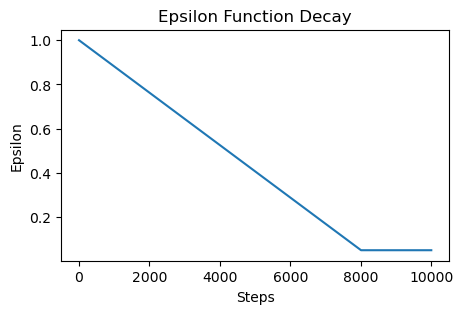

In [3]:
def epsilon_func(i: int, min_value=0.05, max_value=1.0, decay_steps=8000):
        """
        Epsilon decay should linearly decay from max_value to min_value in the first decay_steps,
        and then stay at min_value for the rest of the training.
        """
        if i < decay_steps:
            # Linearly decay epsilon
            return max_value - (max_value - min_value) * (i / decay_steps)
        else:
            # Keep epsilon at min_value after decay_steps
            return min_value
        
def get_epsilon_func(min_value=0.05, max_value=1.0, decay_steps=8000):
    """
    Returns the epsilon function with the specified parameters.
    """
    return partial(epsilon_func, min_value=min_value, max_value=max_value, decay_steps=decay_steps)

values = []
for i in range(0, 10000):
    epsilon = epsilon_func(i)
    values.append(epsilon)

plt.figure(figsize=(5, 3))
plt.plot(values)
plt.xlabel('Steps')
plt.ylabel('Epsilon')
plt.title('Epsilon Function Decay')

In [4]:
# Alpha is just 0.1 for all steps
def alpha_func(i: int, value=0.1):
        return 0.1

def get_alpha_func(value):
    """
    Returns the alpha function with the specified parameters.
    """
    return partial(alpha_func, value=value)

In [5]:
game_configurations = [
    "Foraging-5x5-2p-2f-v3",
    "Foraging-8x8-2p-2f-v3",
    "Foraging-8x8-2p-3f-v3",
    "Foraging-8x8-3p-2f-v3",
    "Foraging-8x8-3p-3f-v3",
    "Foraging-10x10-2p-2f-v3",
]

In [6]:
configurations = {
    "0": {
        "game": game_configurations[0],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    },
    "1": {
        "game": game_configurations[1],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    },
    "2": {
        "game": game_configurations[2],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    },
    "3": {
        "game": game_configurations[3],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    },	
    "4": {
        "game": game_configurations[4],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    },
    "5": {
        "game": game_configurations[5],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": partial(epsilon_func, decay_steps=8000),
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    },
}

## Utility functions

In [7]:
def run(game, agents, verbose=False, render=False, training=True):
    game.reset()
    cum_rewards = dict(map(lambda agent: (agent, 0), game.agents))

    if render:
        game.render()
        time.sleep(2) # Wait for 2 seconds before starting the game

    while not game.done():
        actions = dict(map(lambda agent: (agent, agents[agent].action()), game.agents))
        game.step(actions)

        for agent in game.agents:
            if training:
                # Update the agent only if training is enabled
                agents[agent].update()
            cum_rewards[agent] += game.reward(agent)

        if verbose:
            for agent in game.agents:
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.1)
        
    return cum_rewards

In [8]:
def train(game, agents, iterations, episodes_per_iteration, verbose=False):
    reward_list = {agent: [] for agent in game.agents}
    rewards_per_iteration = {agent: [] for agent in game.agents}
    for i in range(iterations):
        for j in range(episodes_per_iteration):
            cum_rewards = run(game, agents, verbose=False, render=False, training=True)
            for agent in game.agents:
                reward_list[agent].append(cum_rewards[agent])

        for agent in game.agents:
            rewards_per_iteration[agent].append(np.mean(reward_list[agent][-episodes_per_iteration:]))
        if verbose:
            # Print the average rewards for each agent after each iteration
            print(f"Iteration {i+1}, Total Episodes {(j+1)* (i+1)}")
            for agent in game.agents:
                print(f"Agent {agent}, Average reward: {rewards_per_iteration[agent][i]}")
    
    # return the average rewards for each agent after training
    return rewards_per_iteration

In [9]:
def multi_train(configurations, verbose=False):
    all_rewards = {}
    for key, config in configurations.items():
        if verbose:
            print(f"Training configuration {key}: {config}")
        game = Foraging(config=config["game"], seed=config["seed"])
        agents = {
            agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }
        rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=verbose)
        all_rewards[key] = rewards
    return all_rewards

def plot_rewards(rewards, config):
    plt.figure(figsize=(10, 5))
    for agent in rewards:
        plt.plot(rewards[agent], label=f"Agent {agent}")
    plt.title(f"Rewards for Configuration {config['game']}")
    plt.xlabel("Iterations")
    plt.ylabel("Rewards")
    plt.legend()
    plt.grid()
    plt.show()

def plot_multi_rewards(rewards, configurations):
    # Determine the number of rows and columns for subplots
    num_configs = len(rewards)
    cols = 2  # Maximum 2 subplots per row
    rows = (num_configs + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    for i, (key, config) in enumerate(configurations.items()):
        ax = axes[i]
        for agent in rewards[key]:
            ax.plot(rewards[key][agent], label=f"Agent {agent}")
        ax.set_title(f"Rewards for Configuration {key}: {config['game']}")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Rewards")
        ax.legend()
        ax.grid()

    # Hide any unused subplots
    for j in range(num_configs, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    

In [10]:
# all_rewards = multi_train(configurations, verbose=True)
# plot_multi_rewards(all_rewards, configurations)

In [11]:
#run(game, agents, verbose=True, render=True, training=False)

## Foraging: 5x5 - 2 Players - 2 Food

In [12]:
config = {
        "game": game_configurations[0],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.31511111111111106
Agent agent_1, Average reward: 0.6398888888888888
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.33133333333333326
Agent agent_1, Average reward: 0.6616666666666665
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.33099999999999996
Agent agent_1, Average reward: 0.6653333333333332
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.3316666666666666
Agent agent_1, Average reward: 0.6663333333333332
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.3306666666666666
Agent agent_1, Average reward: 0.6623333333333332
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.33233333333333326
Agent agent_1, Average reward: 0.6669999999999999
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.33333333333333326
Agent agent_1, Average reward: 0.6653333333333332
Iteration 8, Total Episodes 8000
Agent agent_0, Average reward: 

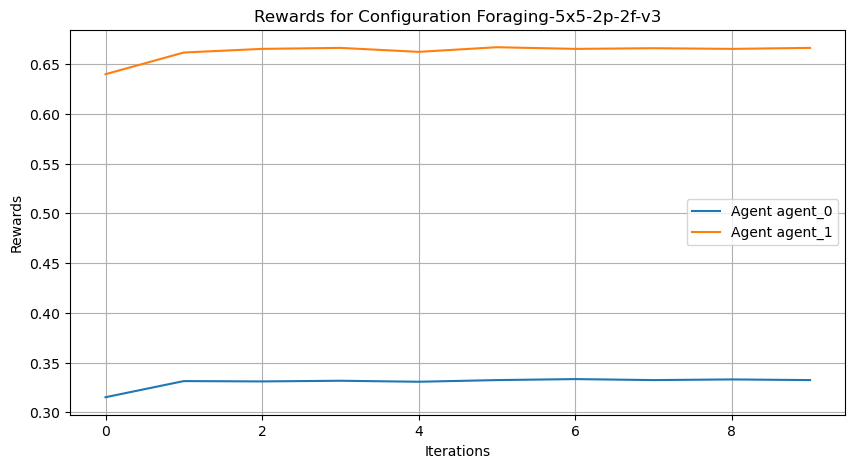

In [13]:
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)

In [14]:
run(game, agents, verbose=True, render=True, training=False)

c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 2. 3. 2. 1. 0. 1. 1. 4. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 2. 3. 2. 1. 4. 2. 1. 0. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 1. 2. 3. 2. 1. 0. 1. 1. 3. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 1. 2. 3. 2. 1. 3. 2. 1. 0. 1.]
Agent agent_0 reward: 0.3333333333333333
Agent agent_0 observe: [-1. -1.  0. -1. -1.  0.  1.  0.  1.  1.  3.  2.]
Agent agent_1 reward: 0.6666666666666666
Agent agent_1 observe: [-1. -1.  0. -1. -1.  0.  1.  3.  2.  1.  0.  1.]


{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## Foraging: 8x8 - 2 Players - 2 Food

In [15]:
config = {
        "game": game_configurations[1],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.32199999999999995
Agent agent_1, Average reward: 0.5303333333333332
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.3306666666666666
Agent agent_1, Average reward: 0.6373333333333333
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.33133333333333326
Agent agent_1, Average reward: 0.6469999999999999
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.33099999999999996
Agent agent_1, Average reward: 0.6466666666666665
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.3312222222222222
Agent agent_1, Average reward: 0.6467777777777776
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.33033333333333326
Agent agent_1, Average reward: 0.6496666666666665
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.3306666666666666
Agent agent_1, Average reward: 0.6403333333333333
Iteration 8, Total Episodes 8000
Agent agent_0, Average reward: 0

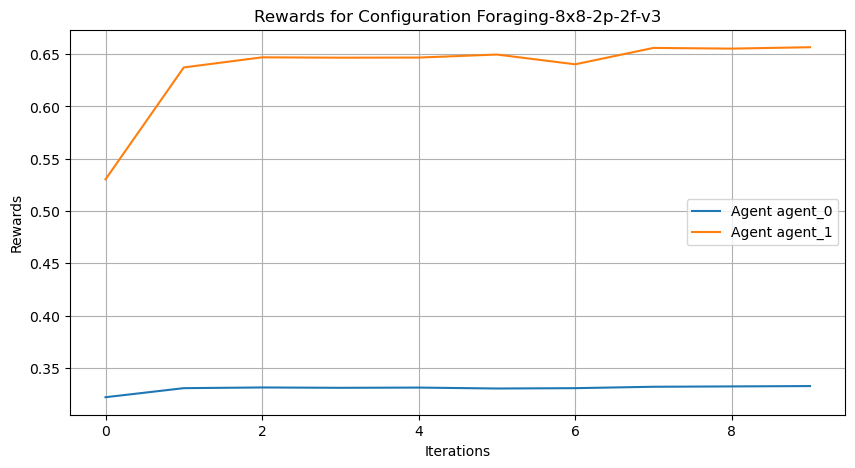

In [16]:
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)

In [17]:
# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0.3333333333333333
Agent agent_0 observe: [ 3.  4.  2. -1. -1.  0.  0.  1.  1.  1.  5.  2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [ 3.  4.  2. -1. -1.  0.  1.  5.  2.  0.  1.  1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [ 3.  4.  2. -1. -1.  0.  0.  1.  1.  1.  4.  2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [ 3.  4.  2. -1. -1.  0.  1.  4.  2.  0.  1.  1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [ 3.  4.  2. -1. -1.  0.  0.  1.  1.  2.  4.  2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [ 3.  4.  2. -1. -1.  0.  2.  4.  2.  0.  1.  1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [-1. -1.  0. -1. -1.  0.  0.  0.  1.  2.  4.  2.]
Agent agent_1 reward: 0.6666666666666666
Agent agent_1 observe: [-1. -1.  0. -1. -1.  0.  2.  4.  2.  0.  0.  1.]


{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## Foraging: 8x8 - 2 Players - 3 Food

In [18]:
config = {
        "game": game_configurations[2],
        "seed": 3,
        "agent": {
            "alpha": alpha_func,
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.03883333333333334
Agent agent_1, Average reward: 0.0955
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.059555555555555556
Agent agent_1, Average reward: 0.13877777777777778
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.06244444444444444
Agent agent_1, Average reward: 0.19322222222222224
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.05505555555555556
Agent agent_1, Average reward: 0.2261111111111111
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.15488888888888885
Agent agent_1, Average reward: 0.4541111111111111
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.1482222222222222
Agent agent_1, Average reward: 0.43344444444444447
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.16944444444444443
Agent agent_1, Average reward: 0.39972222222222215
Iteration 8, Total Episodes 8000
Agent agent_0, Average reward: 0.0925

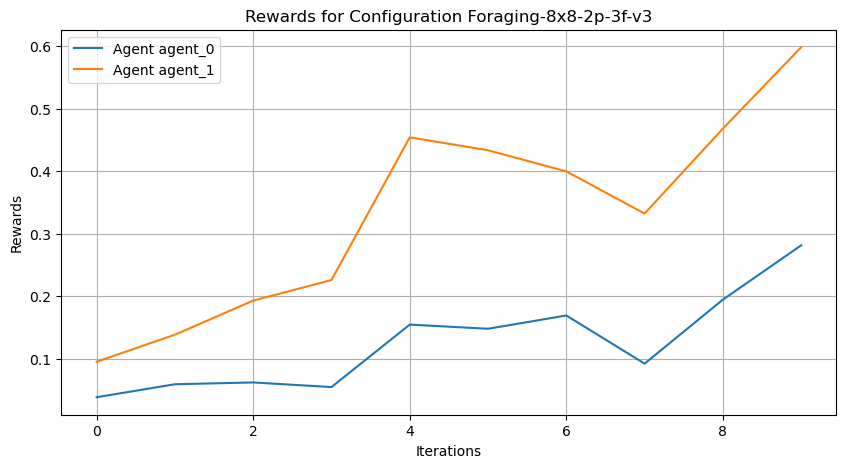

In [19]:
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)

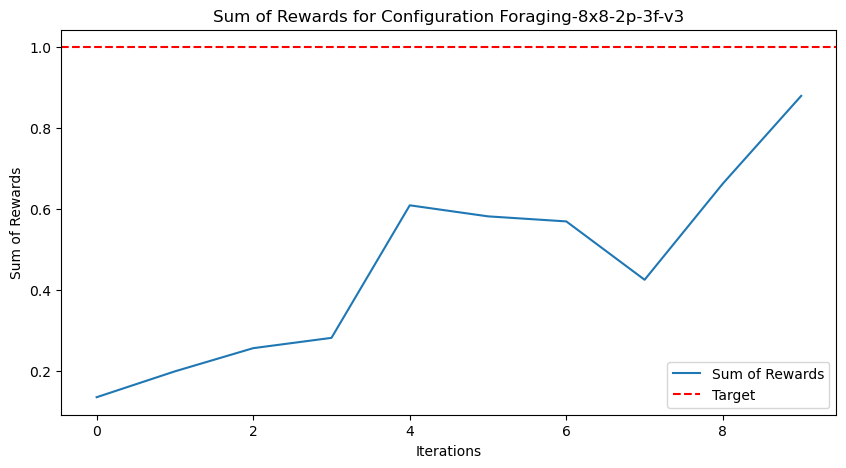

In [20]:
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()


In [21]:
# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 2. 1. 0. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 6. 2. 0. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 2. 1. 1. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 1. 6. 2. 0. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 1. 1. 2. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 2. 6. 2. 0. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 0. 1. 1. 3. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 3. 6. 2. 0. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 1. 1. 1. 3. 6. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 2. 2. 1. 5. 3. 4. 3. 1. 3. 6. 2. 1. 1. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 2. 2. 1. 

{'agent_0': 0.0, 'agent_1': 0}

## Foraging: 8x8 - 2 Players - 2 Food - Coop

In [22]:
config = {
        "game": "Foraging-8x8-2p-2f-coop-v3",
         "seed": 3,
        "agent": {
            "alpha": get_alpha_func(value=0.1),
            "epsilon": get_epsilon_func(decay_steps=8000),
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 20, # Utilizamos 20 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        },
    }

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0003333333333333333
Agent agent_1, Average reward: 0.0006666666666666666
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.00016666666666666666
Agent agent_1, Average reward: 0.0003333333333333333
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0
Agent agent_1, Average reward: 0.0
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0009999999999999998
Agent agent_1, Average reward: 0.0019999999999999996
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.003
Agent agent_1, Average reward: 0.006
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.034666666666666665
Agent agent_1, Average reward: 0.06933333333333333
Iteration 7, Total Episodes 7000
Agent agent_0, Average reward: 0.07566666666666667
Agent agent_1, Average reward: 0.15133333333333335
Iteration 8, Total Episodes 8000
Agent agent_0, Average reward: 0.15049999999999997
Agent agent_1, Av

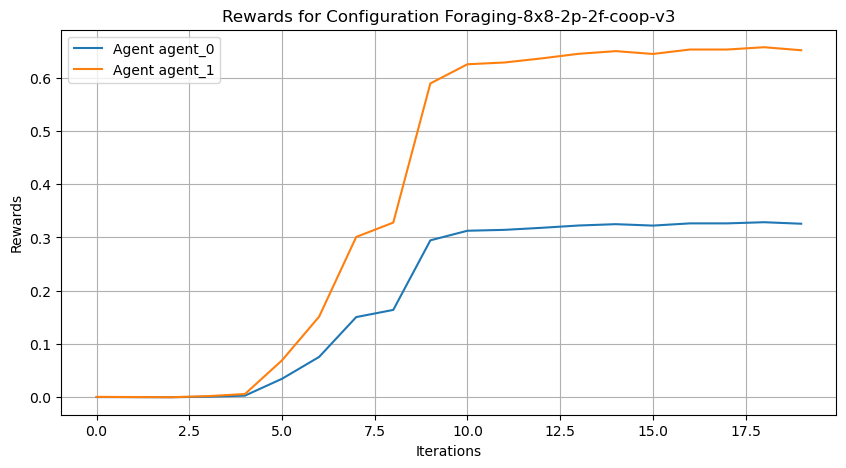

In [23]:
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)

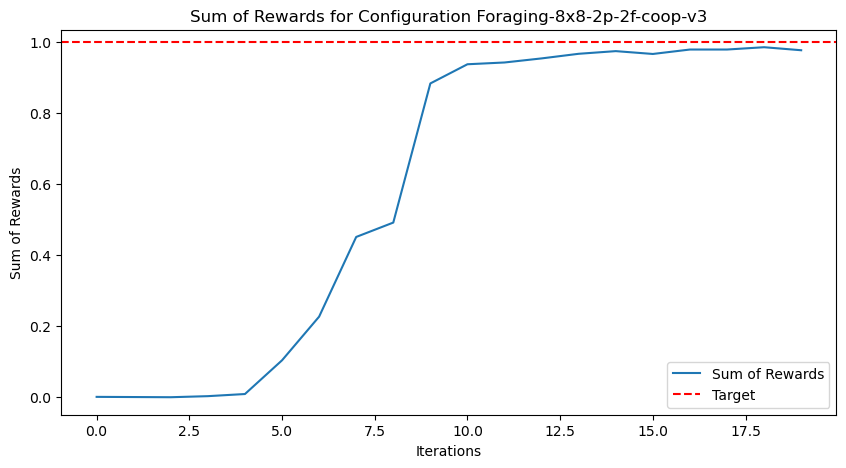

In [24]:
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()

In [25]:
# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 3. 2. 3. 3. 0. 2. 1. 1. 5. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 3. 2. 3. 3. 1. 5. 2. 0. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 3. 2. 3. 3. 1. 2. 1. 1. 4. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 3. 2. 3. 3. 1. 4. 2. 1. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 3. 2. 3. 3. 2. 2. 1. 0. 4. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 3. 2. 3. 3. 0. 4. 2. 2. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 3. 2. 3. 3. 3. 2. 1. 0. 3. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 3. 2. 3. 3. 0. 3. 2. 3. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 1. 3. 2. 3. 3. 3. 3. 1. 1. 3. 2.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 1. 3. 2. 3. 3. 1. 3. 2. 3. 3. 1.]
Agent agent_0 reward: 0.16666666666666666
Agent agent_0 observe: [ 1.  1.  3. -1. -1.  0.  3.  3.  1.  1.  3.  2.]
Agent agent_1 reward: 0.33333333333

{'agent_0': 0.3333333333333333, 'agent_1': 0.6666666666666666}

## Foraging: 8x8 - 3 Players - 1 Food

In [26]:
config = {
        "game": "Foraging-8x8-3p-1f-v3",
        "seed": 1,
        "agent": {
            "alpha": get_alpha_func(value=0.01),
            "epsilon": epsilon_func,
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 10,
            "episodes_per_iteration": 1000,
        },
    }

Training agents in Foraging-8x8-3p-1f-v3, iterations: 10, episodes per iteration: 1000
Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.1383333333333333
Agent agent_1, Average reward: 0.005333333333333333
Agent agent_2, Average reward: 0.003333333333333333
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.15133333333333332
Agent agent_1, Average reward: 0.015166666666666665
Agent agent_2, Average reward: 0.0115
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.171
Agent agent_1, Average reward: 0.0565
Agent agent_2, Average reward: 0.0545
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.094
Agent agent_1, Average reward: 0.1965
Agent agent_2, Average reward: 0.1955
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.033666666666666664
Agent agent_1, Average reward: 0.38583333333333336
Agent agent_2, Average reward: 0.3855
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.087
Agent agent_1, A

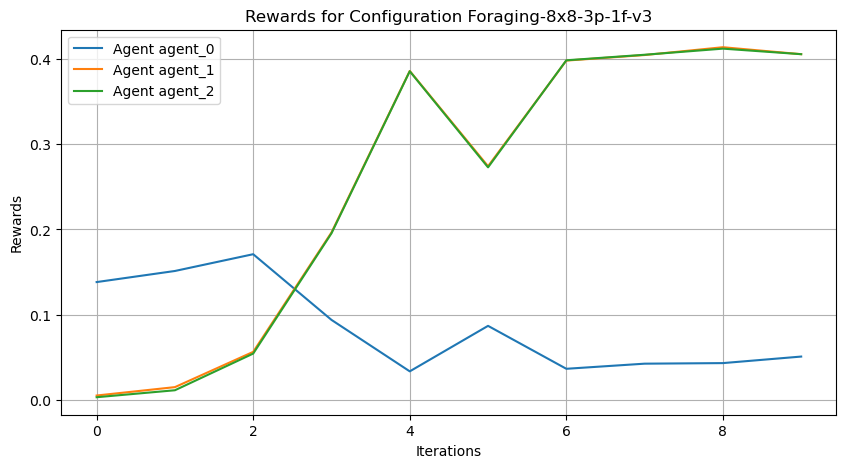

In [27]:
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

print(f"Training agents in {config['game']}, iterations: {config['train']['iterations']}, episodes per iteration: {config['train']['episodes_per_iteration']}")

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)

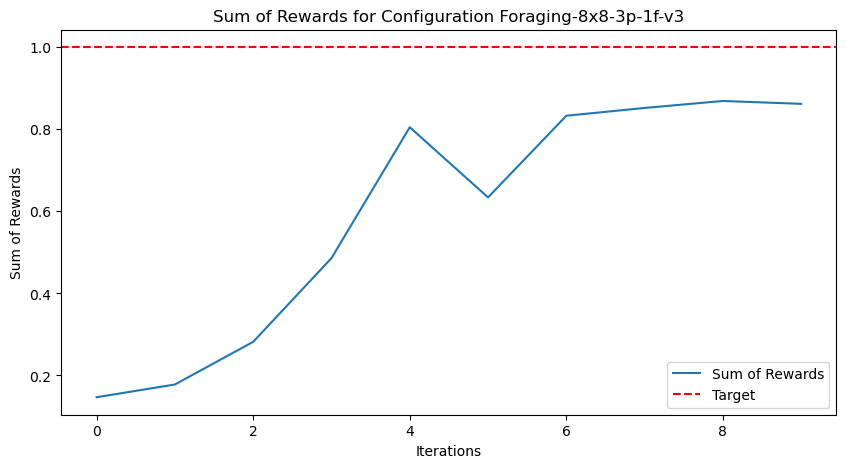

In [28]:
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()


In [29]:
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0
Agent agent_0 observe: [5. 2. 2. 1. 1. 2. 7. 2. 1. 5. 3. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [5. 2. 2. 7. 2. 1. 1. 1. 2. 5. 3. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [5. 2. 2. 5. 3. 1. 1. 1. 2. 7. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [5. 2. 2. 2. 1. 2. 6. 2. 1. 5. 3. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [5. 2. 2. 6. 2. 1. 2. 1. 2. 5. 3. 1.]
Agent agent_2 reward: 0.0
Agent agent_2 observe: [5. 2. 2. 5. 3. 1. 2. 1. 2. 6. 2. 1.]
Agent agent_0 reward: 0
Agent agent_0 observe: [-1. -1.  0.  2.  2.  2.  6.  2.  1.  5.  3.  1.]
Agent agent_1 reward: 0.5
Agent agent_1 observe: [-1. -1.  0.  6.  2.  1.  2.  2.  2.  5.  3.  1.]
Agent agent_2 reward: 0.5
Agent agent_2 observe: [-1. -1.  0.  5.  3.  1.  2.  2.  2.  6.  2.  1.]


{'agent_0': 0, 'agent_1': 0.5, 'agent_2': 0.5}

## Foraging: 8x8 - 3 Players - 2 Food

Esta configuración de ambiente necesita más tiempo de entrenamiento, por lo que aumentamos la cantidad de iteraciones a 100. Además actualizamos la taza de decay de la función epsilon para corresponder a la cantidad de iteraciones.

In [ ]:
config = {
        "game": game_configurations[3],
        "seed": 3,
        "agent": {
            "alpha": get_alpha_func(value=0.1),
            "epsilon": get_epsilon_func(decay_steps=35000), # Cambiamos decay_steps de 8000 a 35000
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 250, # Utilizamos 100 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 100.000 episodios.
    }

AGENT TABLE:  0
AGENT TABLE:  0
AGENT TABLE:  0
Training agents in Foraging-8x8-3p-2f-v3, iterations: 250, episodes per iteration: 1000
Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0011333333333333336
Agent agent_1, Average reward: 0.0884
Agent agent_2, Average reward: 0.0008666666666666668
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0019333333333333333
Agent agent_1, Average reward: 0.07426666666666666
Agent agent_2, Average reward: 0.0014000000000000002
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0012666666666666666
Agent agent_1, Average reward: 0.10146666666666666
Agent agent_2, Average reward: 0.0008666666666666667
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0011333333333333332
Agent agent_1, Average reward: 0.09466666666666668
Agent agent_2, Average reward: 0.0008
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0011333333333333332
Agent agent_1, Average reward: 0.1056
Agent ag

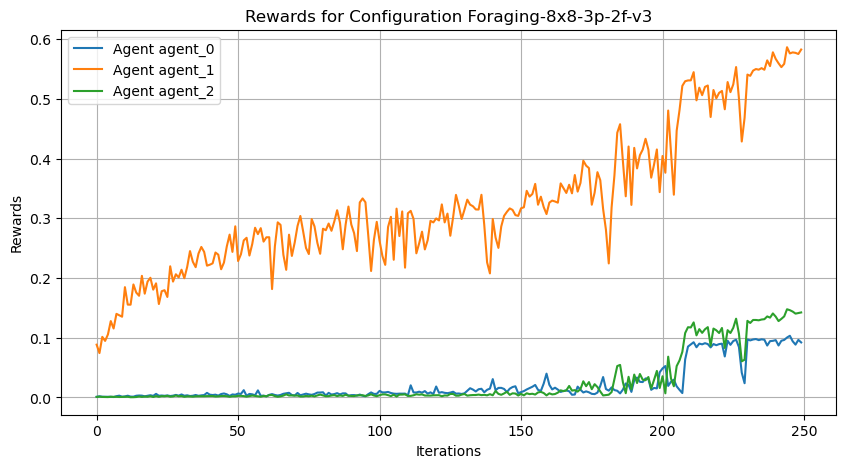

In [16]:
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

print(f"Training agents in {config['game']}, iterations: {config['train']['iterations']}, episodes per iteration: {config['train']['episodes_per_iteration']}")

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)

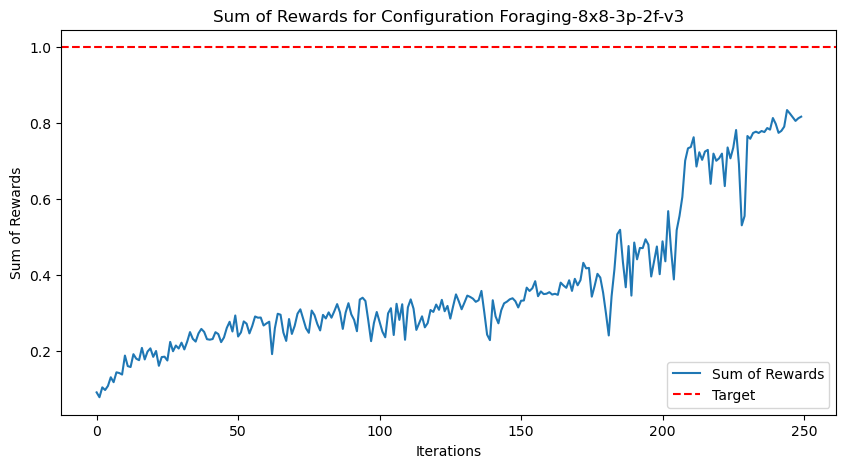

In [17]:
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()


In [34]:
# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 2. 1. 6. 5. 2. 1. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 5. 2. 1. 2. 1. 1. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 1. 0. 1. 1. 2. 1. 6. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 0. 2. 1. 6. 4. 2. 2. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 4. 2. 0. 2. 1. 2. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 2. 0. 1. 0. 2. 1. 6. 4. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 2. 1. 6. 3. 2. 2. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 3. 2. 1. 2. 1. 2. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 2. 0. 1. 1. 2. 1. 6. 3. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 3. 1. 6. 3. 2. 3. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 

{'agent_0': 0, 'agent_1': 0.4, 'agent_2': 0}

## Foraging: 8x8 - 3 Players - 2 Food - Decay longer

In [30]:
config = {
        "game": game_configurations[3],
        "seed": 3,
        "agent": {
            "alpha": get_alpha_func(value=0.1),
            "epsilon": get_epsilon_func(decay_steps=100000), # Cambiamos decay_steps de 8000 a 35000
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 350, # Utilizamos 100 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 100.000 episodios.
    }
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

print(f"Training agents in {config['game']}, iterations: {config['train']['iterations']}, episodes per iteration: {config['train']['episodes_per_iteration']}")

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()

# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=True, render=True, training=False)

c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Training agents in Foraging-8x8-3p-2f-v3, iterations: 350, episodes per iteration: 1000


KeyboardInterrupt: 

## Foraging: 8x8 - 3 Players - 2 Food - New epsilon

In [22]:
def epsilon_v2():
    def epsilon_func(i: int):
        # Define the total period for one full drop and reset
        period = 100000  # Total steps for one full drop and reset
        decay_steps = 35000  # Steps for the linear decay phase
        min_value = 0.05
        max_value = 1.0

        # Determine the position within the current period
        step_in_period = i % period

        if step_in_period < decay_steps:
            # Linearly decay epsilon during the decay phase
            return max_value - (max_value - min_value) * (step_in_period / decay_steps)
        else:
            # Keep epsilon at min_value after the decay phase
            return min_value

    return epsilon_func

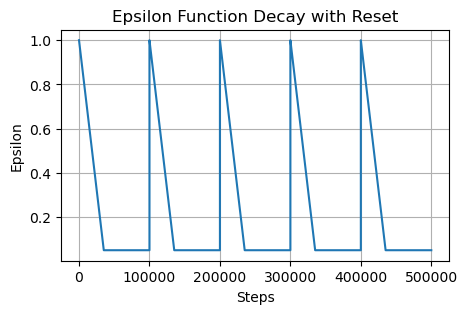

In [23]:
e = epsilon_v2()
values = []

for i in range(0, 500000):
    epsilon = e(i)
    values.append(epsilon)

plt.figure(figsize=(5, 3))
plt.plot(values)
plt.xlabel('Steps')
plt.ylabel('Epsilon')
plt.title('Epsilon Function Decay with Reset')
plt.grid()
plt.show()

Training agents in Foraging-8x8-3p-2f-v3, iterations: 250, episodes per iteration: 1000
Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0008666666666666667
Agent agent_1, Average reward: 0.09119999999999999
Agent agent_2, Average reward: 0.0009333333333333333
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0009333333333333333
Agent agent_1, Average reward: 0.09826666666666665
Agent agent_2, Average reward: 0.0006000000000000001
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0014666666666666667
Agent agent_1, Average reward: 0.09040000000000001
Agent agent_2, Average reward: 0.0007333333333333333
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0018000000000000002
Agent agent_1, Average reward: 0.09546666666666667
Agent agent_2, Average reward: 0.0015333333333333332
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0013333333333333335
Agent agent_1, Average reward: 0.10853333333333333
Agent agent_2, 

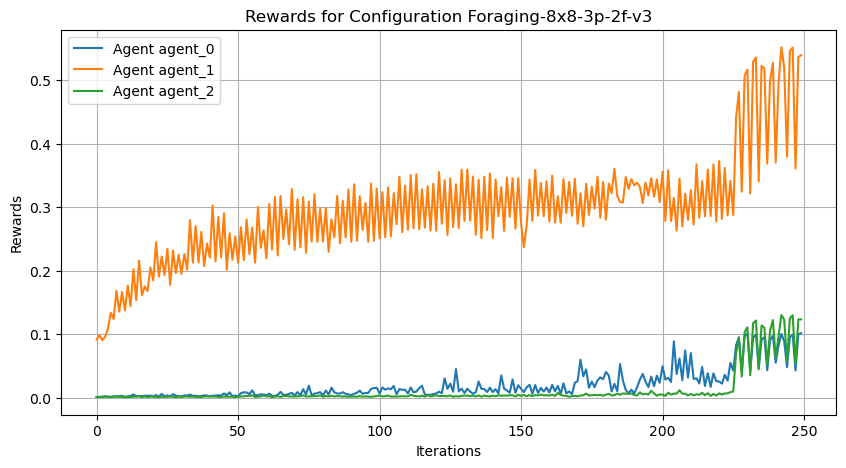

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 1. 1. 5. 6. 2. 0. 0. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 6. 2. 2. 1. 1. 0. 0. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 0. 1. 2. 1. 1. 5. 6. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 3. 1. 1. 5. 5. 2. 0. 1. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 5. 2. 3. 1. 1. 0. 1. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 1. 1. 3. 1. 1. 5. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 3. 2. 1. 5. 4. 2. 1. 1. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 4. 2. 3. 2. 1. 1. 1. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 1. 1. 1. 3. 2. 1. 5. 4. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 3. 3. 1. 4. 4. 2. 1. 2. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 

{'agent_0': 0.13333333333333333, 'agent_1': 0.6666666666666667, 'agent_2': 0.2}

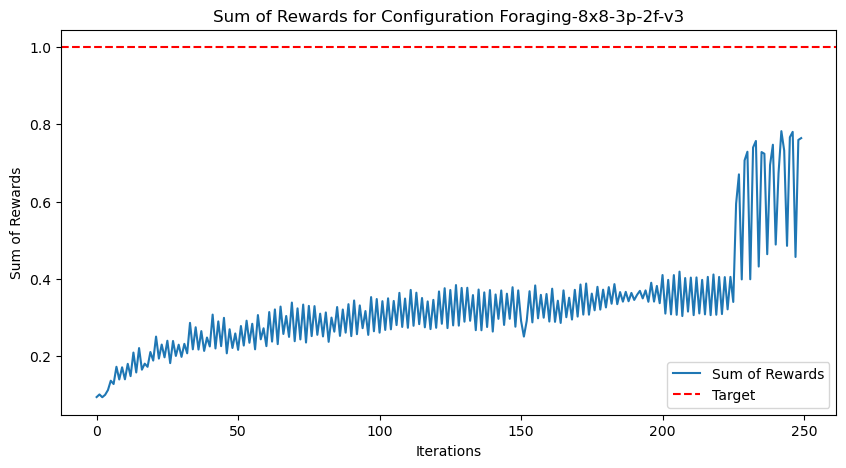

In [24]:
config = {
        "game": game_configurations[3],
        "seed": 3,
        "agent": {
            "alpha": get_alpha_func(value=0.1),
            "epsilon": epsilon_v2(),
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 250, # Utilizamos 100 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 100.000 episodios.
    }
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

print(f"Training agents in {config['game']}, iterations: {config['train']['iterations']}, episodes per iteration: {config['train']['episodes_per_iteration']}")

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()

# Run the agents with render to see how they behave in the environment.
run(game, agents, verbose=True, render=True, training=False)

## Foraging - 8x8 - 3 Players - 2 Food - Retrain 100k

c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\marrt\miniconda3\envs\pettingzoo_games\Lib\site-packages\gymnasium\utils\passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Training agents in Foraging-8x8-3p-2f-v3, iterations: 100, episodes per iteration: 1000
Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0009333333333333333
Agent agent_1, Average reward: 0.08706666666666667
Agent agent_2, Average reward: 0.0008
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0006000000000000001
Agent agent_1, Average reward: 0.0964
Agent agent_2, Average reward: 0.0012000000000000001
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0009333333333333334
Agent agent_1, Average reward: 0.10760000000000002
Agent agent_2, Average reward: 0.0014666666666666667
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0006666666666666668
Agent agent_1, Average reward: 0.12053333333333333
Agent agent_2, Average reward: 0.0
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.001066666666666667
Agent agent_1, Average reward: 0.14079999999999998
Agent agent_2, Average reward: 0.0011333333333333332
Iteration

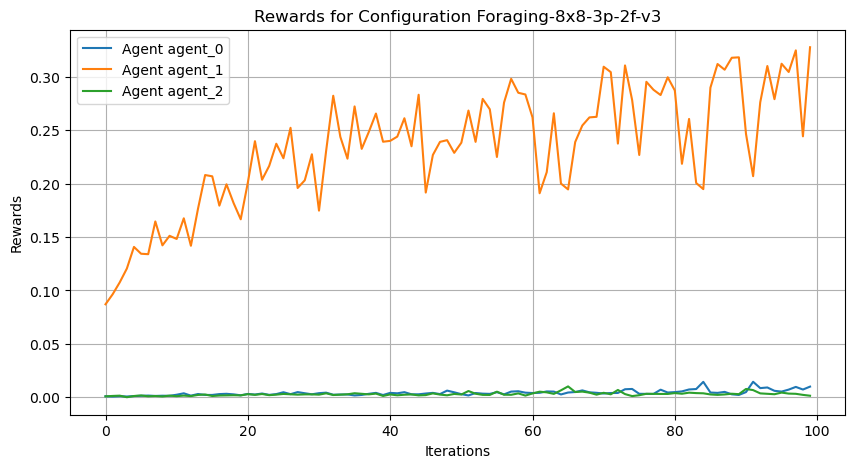

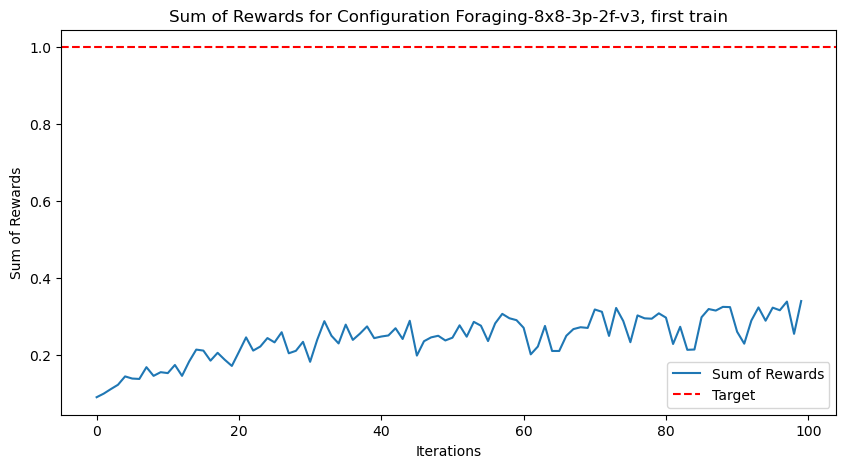

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.004933333333333334
Agent agent_1, Average reward: 0.2917333333333333
Agent agent_2, Average reward: 0.0021333333333333334
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.005266666666666668
Agent agent_1, Average reward: 0.3253333333333333
Agent agent_2, Average reward: 0.0044
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.009533333333333333
Agent agent_1, Average reward: 0.3181333333333333
Agent agent_2, Average reward: 0.0029333333333333334
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.006200000000000001
Agent agent_1, Average reward: 0.31106666666666666
Agent agent_2, Average reward: 0.004333333333333334
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0058000000000000005
Agent agent_1, Average reward: 0.21933333333333332
Agent agent_2, Average reward: 0.005066666666666666
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.00886666

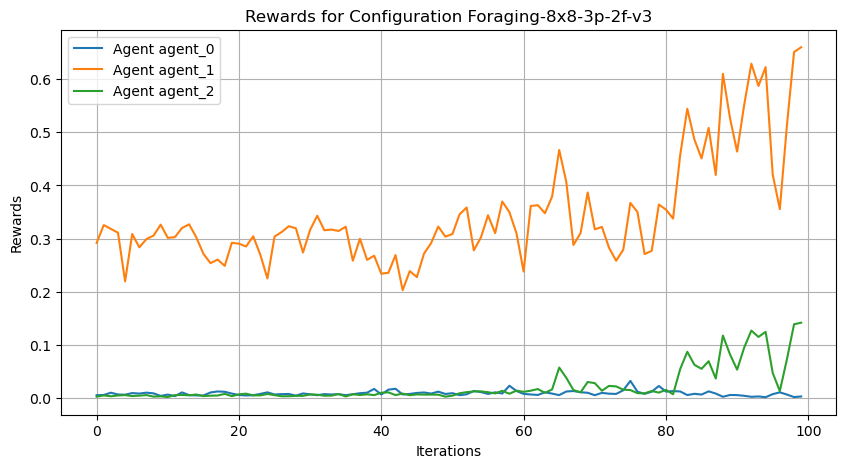

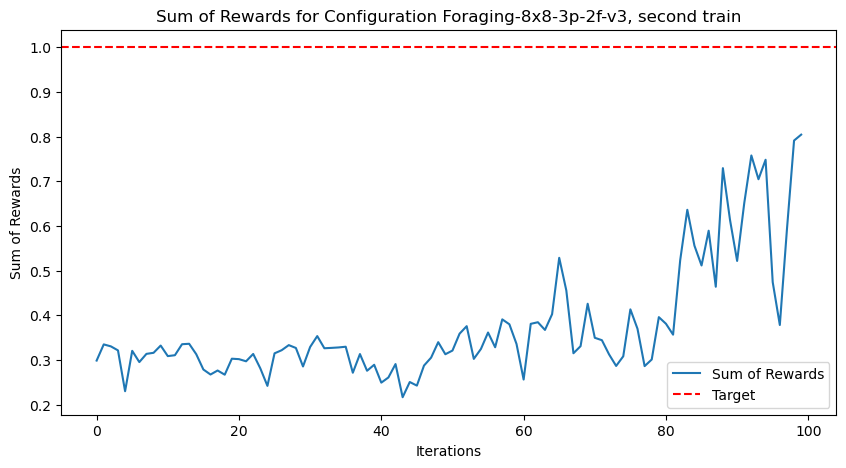

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0011333333333333336
Agent agent_1, Average reward: 0.6636000000000002
Agent agent_2, Average reward: 0.14246666666666666
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0038666666666666667
Agent agent_1, Average reward: 0.5990666666666667
Agent agent_2, Average reward: 0.11606666666666667
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0008
Agent agent_1, Average reward: 0.6766666666666667
Agent agent_2, Average reward: 0.14713333333333334
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.005866666666666667
Agent agent_1, Average reward: 0.5386666666666667
Agent agent_2, Average reward: 0.08986666666666668
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.0032666666666666664
Agent agent_1, Average reward: 0.5994666666666667
Agent agent_2, Average reward: 0.11346666666666666
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.000933333333333

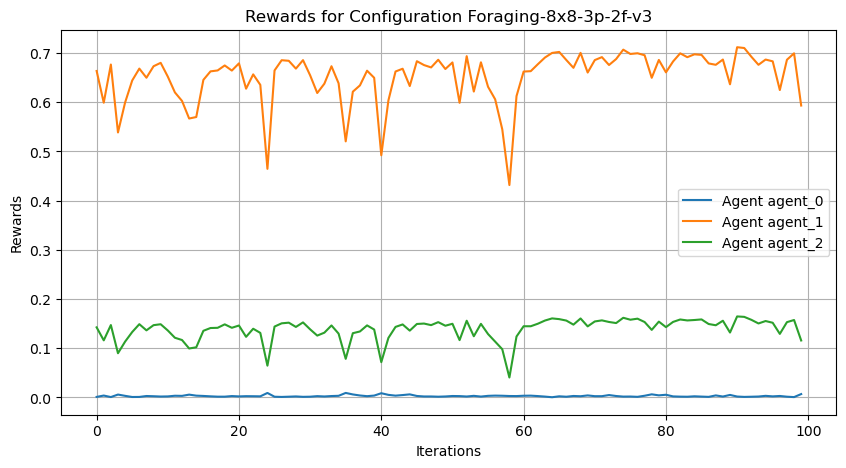

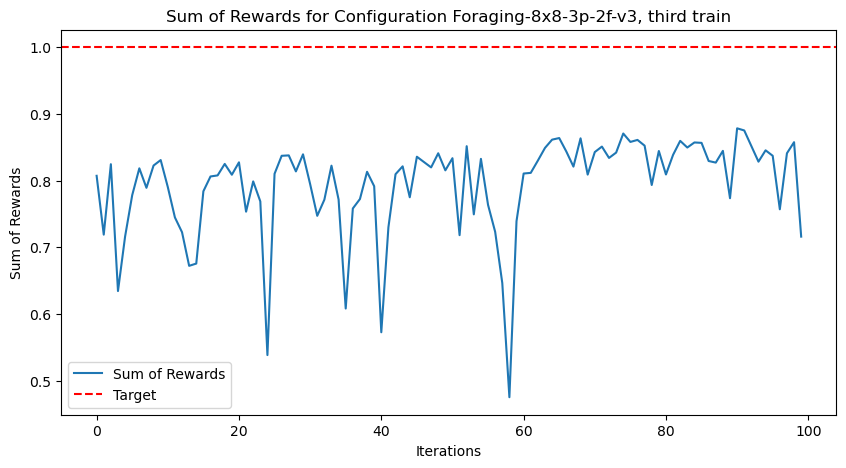

Iteration 1, Total Episodes 1000
Agent agent_0, Average reward: 0.0036
Agent agent_1, Average reward: 0.7070666666666668
Agent agent_2, Average reward: 0.15873333333333334
Iteration 2, Total Episodes 2000
Agent agent_0, Average reward: 0.0024000000000000002
Agent agent_1, Average reward: 0.6997333333333334
Agent agent_2, Average reward: 0.15666666666666665
Iteration 3, Total Episodes 3000
Agent agent_0, Average reward: 0.0020666666666666667
Agent agent_1, Average reward: 0.6817333333333333
Agent agent_2, Average reward: 0.15180000000000002
Iteration 4, Total Episodes 4000
Agent agent_0, Average reward: 0.0022666666666666664
Agent agent_1, Average reward: 0.6984000000000001
Agent agent_2, Average reward: 0.15853333333333333
Iteration 5, Total Episodes 5000
Agent agent_0, Average reward: 0.005666666666666667
Agent agent_1, Average reward: 0.6345333333333335
Agent agent_2, Average reward: 0.12599999999999997
Iteration 6, Total Episodes 6000
Agent agent_0, Average reward: 0.015866666666666

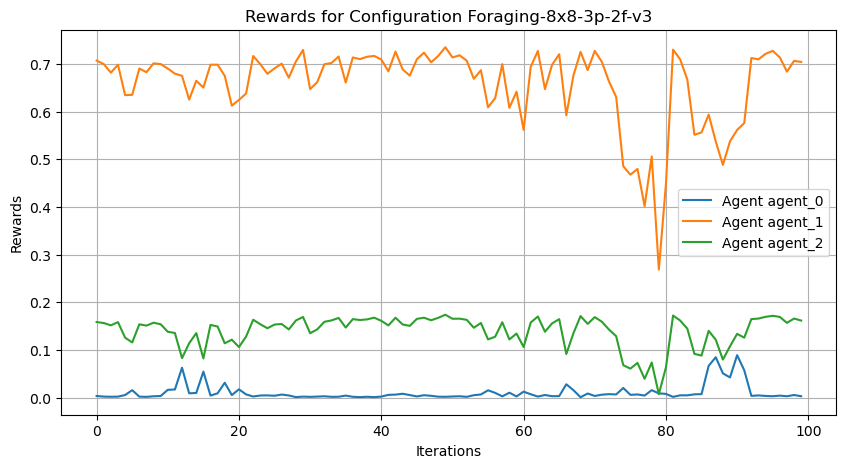

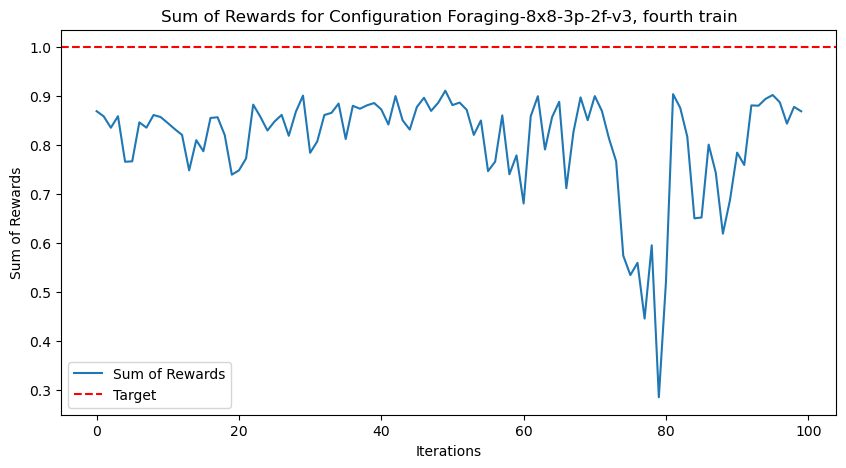

In [28]:
config = {
        "game": game_configurations[3],
        "seed": 3,
        "agent": {
            "alpha": get_alpha_func(value=0.1),
            "epsilon": get_epsilon_func(decay_steps=35000), # Cambiamos decay_steps de 8000 a 35000
            "gamma": 0.9,
            "start_random_q_table": False,
        },
        "train": {
            "iterations": 100, # Utilizamos 100 iteraciones en lugar de 10.
            "episodes_per_iteration": 1000, 
        }, # Esto nos da un total de 100.000 episodios.
    }
game = Foraging(config=config["game"], seed=config["seed"])
agents = {agent: IQL(game, agent, alpha_func=config["agent"]["alpha"], epsilon_func=config["agent"]["epsilon"], 
                     gamma=config["agent"]["gamma"], start_random_q_table=config["agent"]["start_random_q_table"])
            for agent in game.agents
        }

print(f"Training agents in {config['game']}, iterations: {config['train']['iterations']}, episodes per iteration: {config['train']['episodes_per_iteration']}")

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, first train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()


rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, second train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()

for agent in agents.values():
    agent._alpha_value = get_alpha_func(value=0.01)

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, third train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()

rewards = train(game, agents, config["train"]["iterations"], config["train"]["episodes_per_iteration"], verbose=True)
plot_rewards(rewards, config)
# Plot the sum of rewards of all agents in each iteration
plt.figure(figsize=(10, 5))
plt.plot(np.sum(np.array(list(rewards.values())), axis=0), label="Sum of Rewards")
plt.axhline(y=1, color='r', linestyle='--', label="Target")
plt.title(f"Sum of Rewards for Configuration {config['game']}, fourth train")
plt.xlabel("Iterations")
plt.ylabel("Sum of Rewards")
plt.legend()
plt.show()

In [29]:
run(game, agents, verbose=True, render=True, training=False)

Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 1. 2. 1. 6. 5. 2. 0. 1. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 6. 5. 2. 1. 2. 1. 0. 1. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 1. 1. 1. 2. 1. 6. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 2. 1. 5. 5. 2. 0. 2. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 5. 2. 2. 2. 1. 0. 2. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 2. 1. 2. 2. 1. 5. 5. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 2. 1. 5. 4. 2. 0. 3. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 3. 2. 5. 4. 2. 2. 2. 1. 0. 3. 1.]
Agent agent_2 reward: 0
Agent agent_2 observe: [1. 5. 3. 4. 3. 2. 0. 3. 1. 2. 2. 1. 5. 4. 2.]
Agent agent_0 reward: 0
Agent agent_0 observe: [1. 5. 3. 4. 3. 2. 2. 2. 1. 4. 4. 2. 0. 3. 1.]
Agent agent_1 reward: 0
Agent agent_1 observe: [1. 5. 3. 4. 

{'agent_0': 0, 'agent_1': 0.8, 'agent_2': 0.2}